In [82]:
from DecisionTree import DecisionTree
from Model import *
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, auc as AUC

In [2]:
def visualize_decision_tree_networkx(rules):
    G = nx.DiGraph()    
    G.add_node("Root", label="Root", layer=0)
    
    for i, rule in enumerate(rules):
        conditions, outcome = rule.split(' THEN ')
        node_name = f'Node_{i+1}'

        # Parse and round conditions
        rounded_conditions = []
        for cond in conditions.split(' AND '):
            # Find and round all float numbers in the condition string
            rounded_condition = re.sub(r'(\d+\.\d+)', lambda x: f'{float(x.group(0)):0.2f}', cond)
            rounded_conditions.append(rounded_condition)
        
        rounded_conditions = ' AND '.join(rounded_conditions)
        rounded_outcome = tuple(round(float(num), 2) for num in outcome.strip('()').split(', '))
        
        G.add_node(node_name, label=f'{rounded_conditions}\n{rounded_outcome}', layer=1)
        G.add_edge("Root", node_name, label=f'Rule {i+1}')
    
    pos = nx.spring_layout(G)
    pos = {node: (y, -x) for node, (x, y) in pos.items()}
    nx.draw(G, pos, with_labels=True, labels={node: G.nodes[node]['label'] for node in G.nodes}, node_size=5000, node_color='lightblue', font_size=8, font_weight='bold', arrowstyle='-|>', arrowsize=20)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.xlim(min(pos[key][0] for key in pos)-1, max(pos[key][0] for key in pos)+1)
    plt.ylim(min(pos[key][1] for key in pos)-1, max(pos[key][1] for key in pos)+1)
    plt.show()


In [3]:

def get_stats(labels, preds, do_plt = True):
    accuracy = np.sum(preds == labels) / len(labels)
    precision = np.mean([np.sum(labels[preds == x] == x) / np.sum(preds == x) for x in np.unique(preds)])
    recall = np.mean([np.sum(preds[labels == x] == x) / np.sum(labels == x) for x in np.unique(labels)])
    conf = np.array([[np.sum(labels[preds == y] == x) for x in np.unique(labels)] for y in np.unique(labels)])
    if do_plt:
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        fig, ax = plt.subplots(figsize=(4, 4))
        cax = ax.matshow(conf, cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks(ticks=np.arange(len(np.unique(labels))), labels=np.unique(labels))
        plt.yticks(ticks=np.arange(len(np.unique(labels))), labels=np.unique(labels))
    
        # Annotate each cell with the numeric value
        for i in range(len(np.unique(labels))):
            for j in range(len(np.unique(labels))):
                ax.text(j, i, str(conf[i, j]), va='center', ha='center', color='black')
        
        plt.show()
    
    return accuracy, precision, recall, conf


# Dataset COVID

### CART

In [44]:
df = pd.read_csv('dataset/Covid19.csv')
feature_names = df.drop(columns=['label']).columns
data, targets = df.values[:, :-1], df.values[:, -1]
train_data, val_data, train_labels, val_labels = train_test_split(data, targets, test_size = 0.2, random_state = 42)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


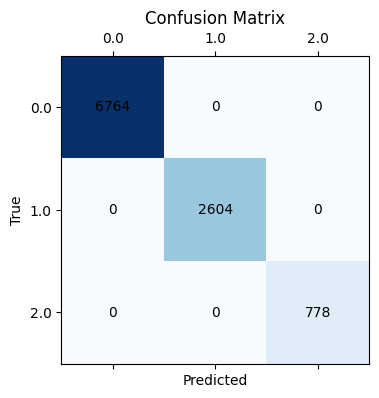

In [45]:
dt = DecisionTree(feature_names, max_depth = 3, method = 'cart')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [46]:
rules = dt.get_rules()

In [47]:
rules

['X6 IS 0.0 AND X3 IS 0.0 AND X2 IS 0.0 THEN (0.0, 0.0)',
 'X6 IS 0.0 AND X3 IS 0.0 AND X2 IS NOT 0.0 THEN (1.0, 1.0)',
 'X6 IS 0.0 AND X3 IS NOT 0.0 THEN (2.0, 0.0)',
 'X6 IS NOT 0.0 THEN (1.0, 1.0)']

In [48]:
print(dt.extract_rules())

|--- infection_order IS 0.00
|   |   |--- province IS 0.00
|   |   |   |   |--- country IS 0.00
|   |   |   |   |   |   |--- class: 0 (0.00)
|   |   |   |   |--- country IS NOT 0.00
|   |   |   |   |   |   |--- class: 1 (1.00)
|   |   |--- province IS NOT 0.00
|   |   |   |   |--- class: 2 (0.00)
|--- infection_order IS NOT 0.00
|   |   |--- class: 1 (1.00)


### C4.5

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


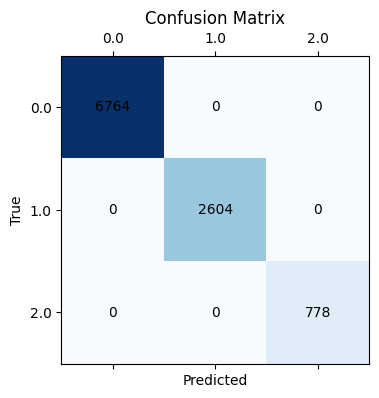

In [49]:
dt = DecisionTree(feature_names, max_depth = 3, method = 'c4.5')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [50]:
rules = dt.get_rules()

In [51]:
rules

['X3 IS 0.0 AND X6 IS 0.0 AND X2 IS 0.0 THEN (0.0, 0.0)',
 'X3 IS 0.0 AND X6 IS 0.0 AND X2 IS 1.0 THEN (1.0, 1.0)',
 'X3 IS 0.0 AND X6 IS 1.0 THEN (1.0, 1.0)',
 'X3 IS 0.0 AND X6 IS 2.0 THEN (1.0, 1.0)',
 'X3 IS 0.0 AND X6 IS 3.0 THEN (1.0, 1.0)',
 'X3 IS 1.0 THEN (2.0, 0.0)']

In [52]:
print(dt.extract_rules())

|--- province IS 0.00
|   |   |--- infection_order IS 0.00
|   |   |   |   |--- country IS 0.00
|   |   |   |   |   |   |--- class: 0 (0.00)
|   |   |   |   |--- country IS 1.00
|   |   |   |   |   |   |--- class: 1 (1.00)
|   |   |--- infection_order IS 1.00
|   |   |   |   |--- class: 1 (1.00)
|   |   |--- infection_order IS 2.00
|   |   |   |   |--- class: 1 (1.00)
|   |   |--- infection_order IS 3.00
|   |   |   |   |--- class: 1 (1.00)
|--- province IS 1.00
|   |   |--- class: 2 (0.00)


## OVA and OVO

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


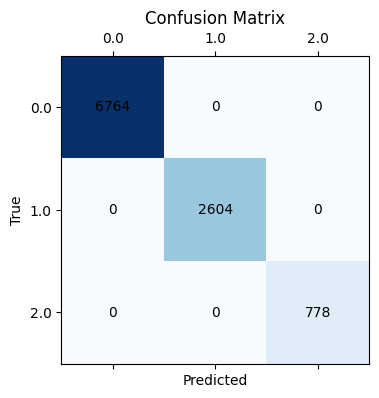

In [53]:
ova_tree = OnevsAll(DecisionTree, max_depth = 3, method = 'cart')
ova_tree.fit(train_data, train_labels)
preds = ova_tree.predict(val_data)
stat = get_stats(val_labels, preds)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


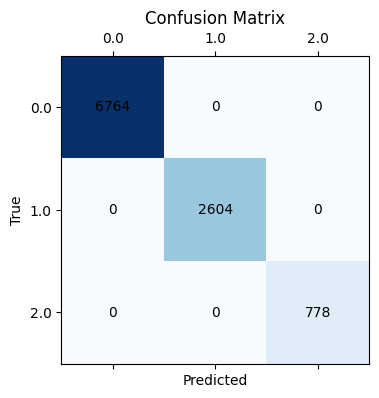

In [54]:
ovo_tree = OnevsOne(DecisionTree, max_depth = 3)
ovo_tree.fit(train_data, train_labels)
preds = ovo_tree.predict(val_data)
stat = get_stats(val_labels, preds)

## All data

### sickit learn classifier

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


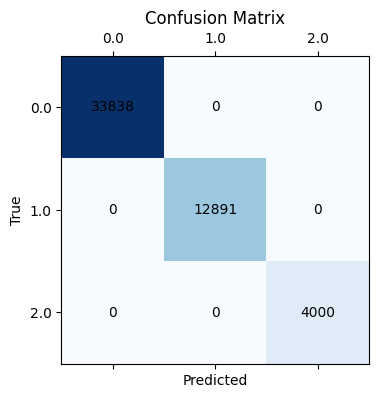

In [55]:
dtc = DecisionTreeClassifier(max_depth = 3)
dtc.fit(train_data, train_labels)
preds = dtc.predict(data)
stat = get_stats(targets, preds)

In [56]:
from sklearn import tree
text_representation = tree.export_text(dtc,feature_names=feature_names)
print(text_representation)

|--- infection_order <= 0.50
|   |--- elementary_school_count <= 0.50
|   |   |--- country <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- country >  0.50
|   |   |   |--- class: 1.0
|   |--- elementary_school_count >  0.50
|   |   |--- class: 2.0
|--- infection_order >  0.50
|   |--- class: 1.0



### our model

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


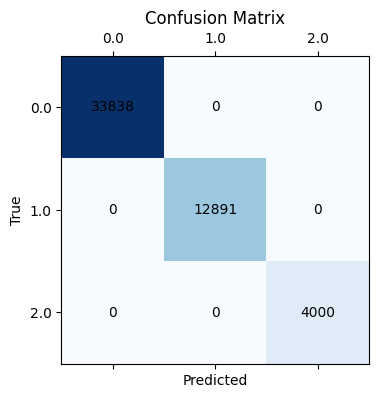

In [57]:
dt = DecisionTree(feature_names, max_depth = 3, method = 'cart')
dt.fit(data, targets)
preds = dt.predict(data)
stat = get_stats(targets, preds)

In [58]:
dt.get_rules()

['X6 IS 0.0 AND X3 IS 0.0 AND X2 IS 0.0 THEN (0.0, 0.0)',
 'X6 IS 0.0 AND X3 IS 0.0 AND X2 IS NOT 0.0 THEN (1.0, 1.0)',
 'X6 IS 0.0 AND X3 IS NOT 0.0 THEN (2.0, 0.0)',
 'X6 IS NOT 0.0 THEN (1.0, 1.0)']

In [59]:
print(dt.extract_rules())

|--- infection_order IS 0.00
|   |   |--- province IS 0.00
|   |   |   |   |--- country IS 0.00
|   |   |   |   |   |   |--- class: 0 (0.00)
|   |   |   |   |--- country IS NOT 0.00
|   |   |   |   |   |   |--- class: 1 (1.00)
|   |   |--- province IS NOT 0.00
|   |   |   |   |--- class: 2 (0.00)
|--- infection_order IS NOT 0.00
|   |   |--- class: 1 (1.00)


# Dataset Heart

In [62]:
from EnsembleLearning import SMOTE

In [143]:
file_path = 'dataset/heart.csv'
data = pd.read_csv(file_path)
features = data.drop(columns=['DEATH_EVENT', 'time'])
feature_names = features.columns
targets = data['DEATH_EVENT'].values
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
data = pd.DataFrame(normalized_features, columns=features.columns).values
unique_labels, counts = np.unique(targets, return_counts=True)
class_weights = {label: sum(counts) / count for label, count in zip(unique_labels, counts)}
print(class_weights)
sm = SMOTE()
sm.fit(data, targets)
new_art_data, new_art_labels = sm.resample()

{0: 1.4729064039408868, 1: 3.1145833333333335}


In [144]:
train_data, val_data, train_labels, val_labels = train_test_split(new_art_data, new_art_labels, test_size = 0.2, random_state = 42)

## CART

Accuracy: 0.8049
Precision: 0.8056
Recall: 0.8049


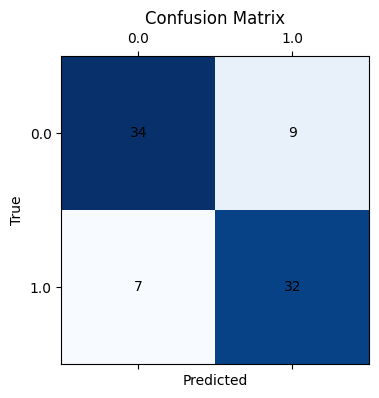

In [145]:
dt = DecisionTree(feature_names,max_depth = 3, method = 'cart')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [146]:
rules = dt.get_rules()

In [147]:
rules

['X4 < 0.3157560972147388 AND X7 < 0.056866402071455754 AND X4 < 0.20454545454545456 THEN (1.0, 0.6428571428571429)',
 'X4 < 0.3157560972147388 AND X7 < 0.056866402071455754 AND X4 >= 0.20454545454545456 THEN (0.0, 0.07692307692307687)',
 'X4 < 0.3157560972147388 AND X7 >= 0.056866402071455754 AND X2 < 0.005358509823934677 THEN (0.0, 0.0)',
 'X4 < 0.3157560972147388 AND X7 >= 0.056866402071455754 AND X2 >= 0.005358509823934677 THEN (1.0, 0.8818181818181818)',
 'X4 >= 0.3157560972147388 AND X7 < 0.14775280898876403 AND X0 < 0.6967462295797703 THEN (0.0, 0.15217391304347827)',
 'X4 >= 0.3157560972147388 AND X7 < 0.14775280898876403 AND X0 >= 0.6967462295797703 THEN (1.0, 0.6875)',
 'X4 >= 0.3157560972147388 AND X7 >= 0.14775280898876403 AND X6 < 0.3933068067523188 THEN (1.0, 0.88)',
 'X4 >= 0.3157560972147388 AND X7 >= 0.14775280898876403 AND X6 >= 0.3933068067523188 THEN (0.0, 0.33333333333333337)']

In [148]:
print(dt.extract_rules())

|--- ejection_fraction < 0.32
|   |   |--- serum_creatinine < 0.06
|   |   |   |   |--- ejection_fraction < 0.20
|   |   |   |   |   |   |--- class: 1 (0.64)
|   |   |   |   |--- ejection_fraction >= 0.20
|   |   |   |   |   |   |--- class: 0 (0.08)
|   |   |--- serum_creatinine >= 0.06
|   |   |   |   |--- creatinine_phosphokinase < 0.01
|   |   |   |   |   |   |--- class: 0 (0.00)
|   |   |   |   |--- creatinine_phosphokinase >= 0.01
|   |   |   |   |   |   |--- class: 1 (0.88)
|--- ejection_fraction >= 0.32
|   |   |--- serum_creatinine < 0.15
|   |   |   |   |--- age < 0.70
|   |   |   |   |   |   |--- class: 0 (0.15)
|   |   |   |   |--- age >= 0.70
|   |   |   |   |   |   |--- class: 1 (0.69)
|   |   |--- serum_creatinine >= 0.15
|   |   |   |   |--- platelets < 0.39
|   |   |   |   |   |   |--- class: 1 (0.88)
|   |   |   |   |--- platelets >= 0.39
|   |   |   |   |   |   |--- class: 0 (0.33)


## C4.5

Accuracy: 0.7927
Precision: 0.8015
Recall: 0.7927


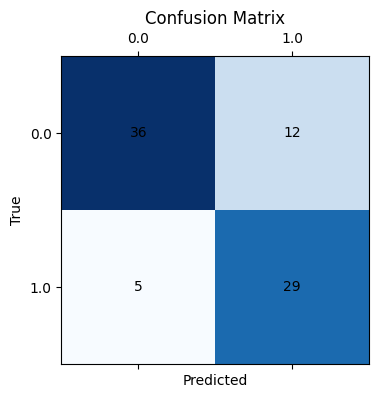

In [149]:
dt = DecisionTree(feature_names, max_depth = 3, method = 'c4.5')
dt.fit(train_data, train_labels)
preds = dt.predict(val_data)
stat = get_stats(val_labels, preds)

In [150]:
rules = dt.get_rules()

In [151]:
rules

['X4 < 0.3157560972147388 AND X2 < 0.005358509823934677 THEN (0.0, 0.16666666666666663)',
 'X4 < 0.3157560972147388 AND X2 >= 0.005358509823934677 AND X7 < 0.056866402071455754 THEN (0.0, 0.34615384615384615)',
 'X4 < 0.3157560972147388 AND X2 >= 0.005358509823934677 AND X7 >= 0.056866402071455754 THEN (1.0, 0.8818181818181818)',
 'X4 >= 0.3157560972147388 AND X7 < 0.14775280898876403 AND X0 < 0.6967462295797703 THEN (0.0, 0.15217391304347827)',
 'X4 >= 0.3157560972147388 AND X7 < 0.14775280898876403 AND X0 >= 0.6967462295797703 THEN (1.0, 0.6875)',
 'X4 >= 0.3157560972147388 AND X7 >= 0.14775280898876403 AND X6 < 0.3933068067523188 THEN (1.0, 0.88)',
 'X4 >= 0.3157560972147388 AND X7 >= 0.14775280898876403 AND X6 >= 0.3933068067523188 THEN (0.0, 0.33333333333333337)']

In [152]:
print(dt.extract_rules())

|--- ejection_fraction < 0.32
|   |   |--- creatinine_phosphokinase < 0.01
|   |   |   |   |--- class: 0 (0.17)
|   |   |--- creatinine_phosphokinase >= 0.01
|   |   |   |   |--- serum_creatinine < 0.06
|   |   |   |   |   |   |--- class: 0 (0.35)
|   |   |   |   |--- serum_creatinine >= 0.06
|   |   |   |   |   |   |--- class: 1 (0.88)
|--- ejection_fraction >= 0.32
|   |   |--- serum_creatinine < 0.15
|   |   |   |   |--- age < 0.70
|   |   |   |   |   |   |--- class: 0 (0.15)
|   |   |   |   |--- age >= 0.70
|   |   |   |   |   |   |--- class: 1 (0.69)
|   |   |--- serum_creatinine >= 0.15
|   |   |   |   |--- platelets < 0.39
|   |   |   |   |   |   |--- class: 1 (0.88)
|   |   |   |   |--- platelets >= 0.39
|   |   |   |   |   |   |--- class: 0 (0.33)


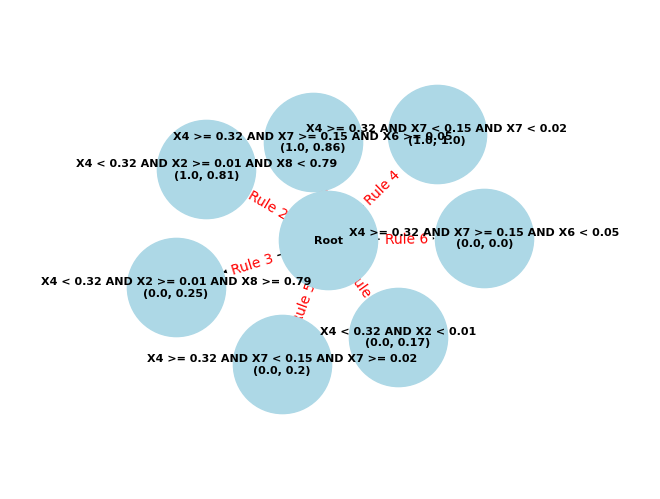

In [30]:
visualize_decision_tree_networkx(rules)

## All data

Accuracy: 0.8161
Precision: 0.7914
Recall: 0.7794


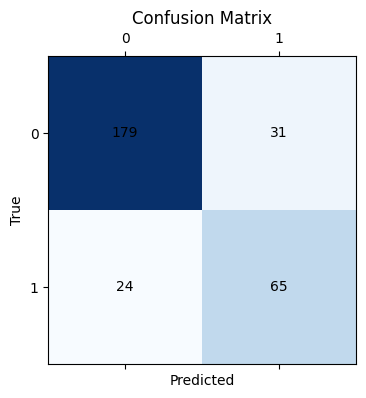

In [77]:
dt = DecisionTree(feature_names, max_depth = 3, method = 'cart')
dt.fit(data, targets)
preds = dt.predict(data)
stat = get_stats(targets, preds)

In [78]:
print(dt.extract_rules())

|--- serum_creatinine < 0.15
|   |   |--- ejection_fraction < 0.20
|   |   |   |   |--- serum_sodium < 0.86
|   |   |   |   |   |   |--- class: 1 (0.62)
|   |   |   |   |--- serum_sodium >= 0.86
|   |   |   |   |   |   |--- class: 0 (0.00)
|   |   |--- ejection_fraction >= 0.20
|   |   |   |   |--- age < 0.72
|   |   |   |   |   |   |--- class: 0 (0.13)
|   |   |   |   |--- age >= 0.72
|   |   |   |   |   |   |--- class: 1 (0.71)
|--- serum_creatinine >= 0.15
|   |   |--- serum_creatinine < 0.17
|   |   |   |   |--- class: 1 (1.00)
|   |   |--- serum_creatinine >= 0.17
|   |   |   |   |--- serum_sodium < 0.61
|   |   |   |   |   |   |--- class: 1 (0.76)
|   |   |   |   |--- serum_sodium >= 0.61
|   |   |   |   |   |   |--- class: 0 (0.38)


## scikit classifier

Accuracy: 0.7333
Precision: 0.7343
Recall: 0.7086


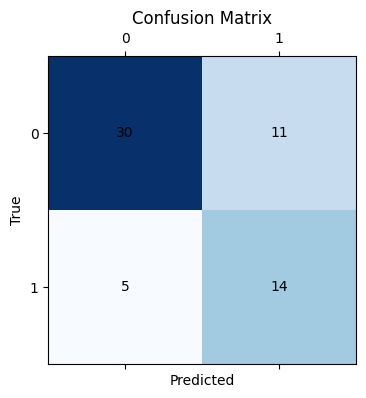

In [79]:
train_data, val_data, train_labels, val_labels = train_test_split(data, targets, test_size = 0.2, random_state = 42)
dtc = DecisionTreeClassifier(max_depth = 3)
dtc.fit(train_data, train_labels)
preds = dtc.predict(val_data)
stat = get_stats(val_labels, preds)

In [80]:
from sklearn import tree
text_representation = tree.export_text(dtc,feature_names=feature_names)
print(text_representation)

|--- serum_creatinine <= 0.15
|   |--- ejection_fraction <= 0.28
|   |   |--- serum_creatinine <= 0.05
|   |   |   |--- class: 0
|   |   |--- serum_creatinine >  0.05
|   |   |   |--- class: 1
|   |--- ejection_fraction >  0.28
|   |   |--- age <= 0.72
|   |   |   |--- class: 0
|   |   |--- age >  0.72
|   |   |   |--- class: 1
|--- serum_creatinine >  0.15
|   |--- serum_creatinine <= 0.17
|   |   |--- class: 1
|   |--- serum_creatinine >  0.17
|   |   |--- ejection_fraction <= 0.34
|   |   |   |--- class: 0
|   |   |--- ejection_fraction >  0.34
|   |   |   |--- class: 1



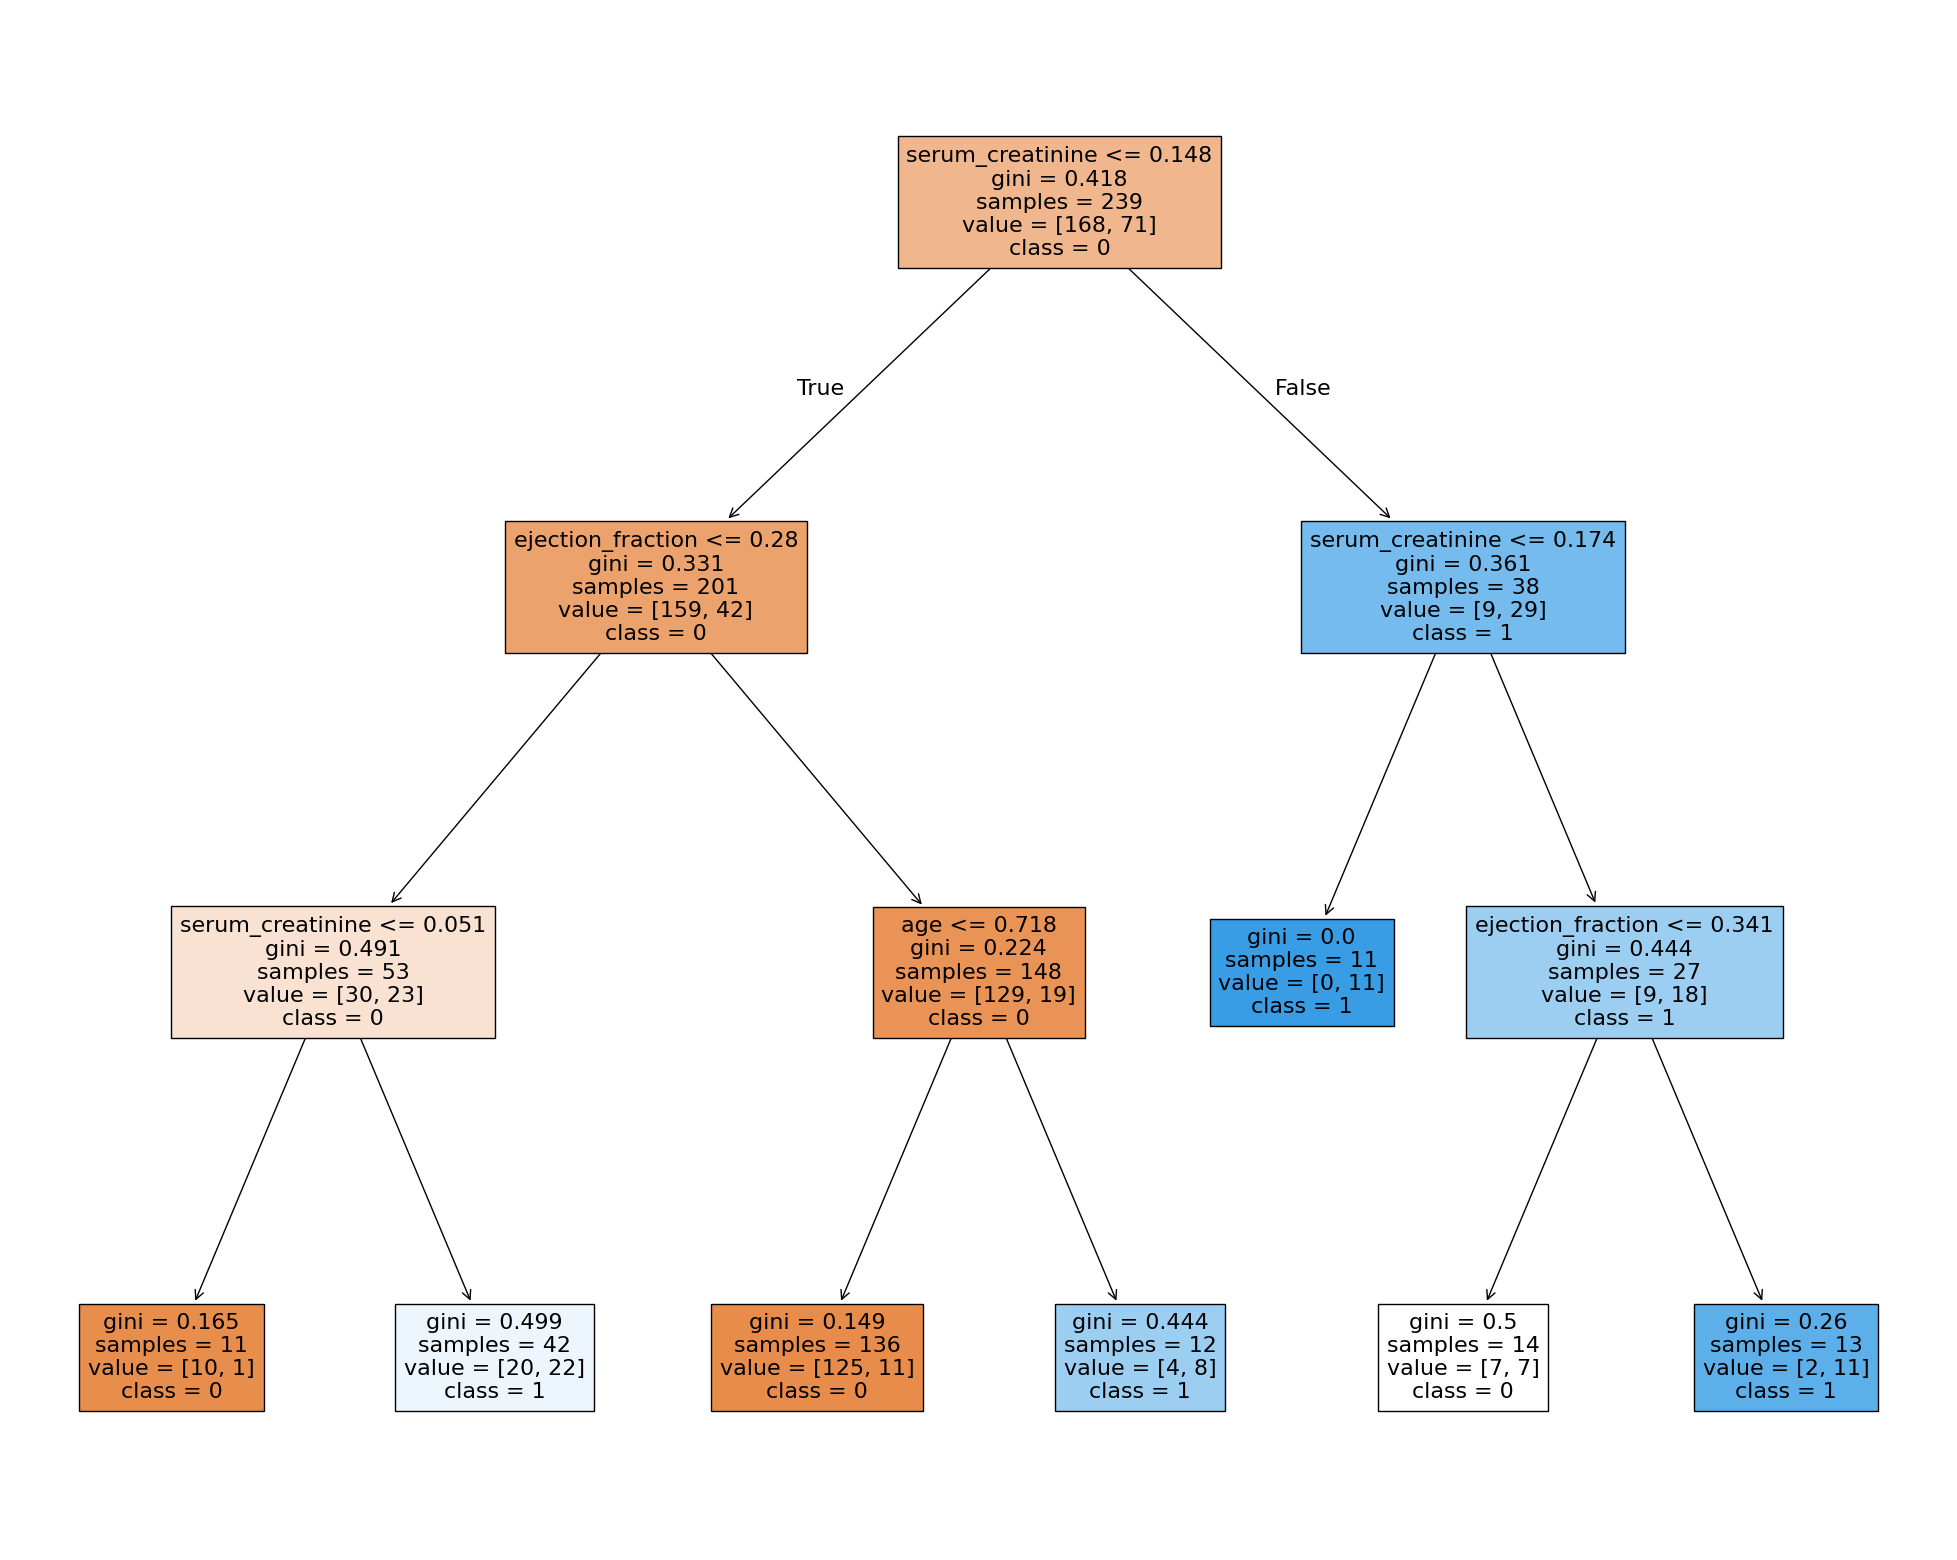

In [81]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, 
                   feature_names=feature_names,  
                   class_names=['0','1'],
                   filled=True)

Best max_depth: 3 with cross-validated accuracy: 0.7333


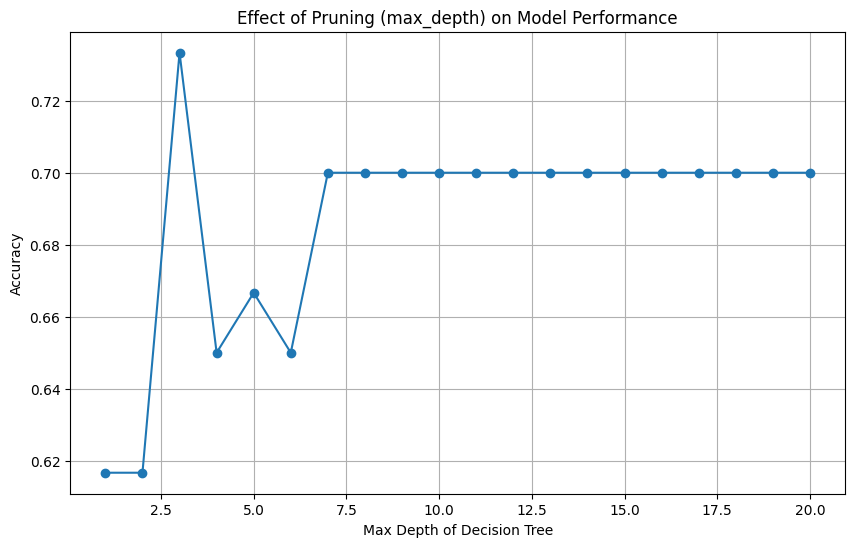

In [36]:
max_depths = range(1, 21)
cv_scores = []

for i in max_depths:
    dt = DecisionTree(feature_names, max_depth = i, method = 'cart')
    dt.fit(train_data, train_labels)
    preds = dt.predict(val_data)
    stat = get_stats(val_labels, preds, False)
    cv_scores.append(stat[0])

best_max_depth = max_depths[np.argmax(cv_scores)]
print(f'Best max_depth: {best_max_depth} with cross-validated accuracy: {max(cv_scores):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(max_depths, cv_scores, marker='o')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.title('Effect of Pruning (max_depth) on Model Performance')
plt.grid(True)
plt.show()